**Outline:**
* Load GLODAP alk, dic, tem, sal, sil, phos, pH
* Load bgc-argo pH
* Load SOCAT fCO2
* Scatter-plot pH calculated from core GLODAP variables against pH measured in GLODAP
* Scatter-plot pH calculated from core GLODAP variables against pH measured in bgc-argo
* Scatter-plot fCO2 calculated from core GLODAP variables against fCO2 measured in SOCAT

#### Load necessary packages

In [47]:
import os
import sys
sys.path.insert(0,'../../mocsy')

fig_path = "/home/friedrich/Nextcloud/physik/CAS_AML/"\
    "Final_Project/MOCCA/report/source_files/figures/"

In [48]:
import numpy as np
import xarray as xr
import pandas as pd
from tqdm import tqdm
import pickle 
import random
import matplotlib.pyplot as plt
from scipy import stats
import scipy

import mocsy
from mocsy import mvars
from mocsy import mrhoinsitu
from mocsy import mrho

In [67]:
def extend(number, template):
    """
    helper function allowing calc_fco2 to work on floats and arrays.
    """
    template_type = "array" if isinstance(template, np.ndarray) else "float"
    if template_type == "array":
        return number * np.ones(template.shape)
    elif template_type == "float":
        return number

def calc_fCO2(alk, dic, tem, sal, sil, phos):
    """
    input units
    alk in mol / kg
    dic in mol / kg
    tem in °C
    sal in PSU
    sil in mol / kg
    phos in mol / kg
    """
    return mvars(alk=alk,
                     dic=dic,
                     temp=tem,
                     sal=sal,
                     sil=sil,
                     phos=phos,
                     patm=extend(1, alk),
                     depth=extend(5, alk),
                     lat=extend(np.nan, alk),
                     optcon='mol/kg',
                     optt='Tpot',
                     optp='db',
                     optk1k2='l',
                     optb='u74',
                     optkf='pf',
                     opts='Sprc')[2]

def calc_pH(alk, dic, tem, sal, sil, phos):
    """
    input units
    alk in mol / kg
    dic in mol / kg
    tem in °C
    sal in PSU
    sil in mol / kg
    phos in mol / kg
    """
    return mvars(alk=alk,
                     dic=dic,
                     temp=tem,
                     sal=sal,
                     sil=sil,
                     phos=phos,
                     patm=extend(1, alk),
                     depth=extend(5, alk),
                     lat=extend(np.nan, alk),
                     optcon='mol/kg',
                     optt='Tpot',
                     optp='db',
                     optk1k2='l',
                     optb='u74',
                     optkf='pf',
                     opts='Sprc')[0]

def MSE(x, y):
    return np.sum((x-y)**2)/len(x)

def FVU(yestim, y):
    """
    Fraction of variance unexplained
    """
    return np.mean((yestim-y)**2) / np.var(y) 

# Read in the data

#### Read in the observational data

In [68]:
ds_socat = xr.open_dataset("../data/SOCATv2023_tracks_gridded_monthly.nc").sel(tmnth=slice('1993-01-01', '2022-12-31'))
ds_bgcargo = xr.open_dataset("../data/202405-BgcArgoSprof_pH_gridded.nc")
ds_glodap_4vars = xr.open_dataset("../data/GLODAPv2.2023_gridded_talk_tco2_silicate_phosphate_pH_fCO2.nc")

In [69]:
data = {}
data["fco2"] = ds_socat.fco2_ave_weighted.values

data["ph"] = ds_bgcargo.PH_IN_SITU_TOTAL_ADJUSTED_gridded.values

data["talkos_4"] = ds_glodap_4vars.G2talk.values * 1e-6 # to go from mumol kg-1 to mol kg-1
data["dissicos_4"] = ds_glodap_4vars.G2tco2.values * 1e-6
data["sios_4"] = ds_glodap_4vars.G2silicate.values * 1e-6
data["po4os_4"] = ds_glodap_4vars.G2phosphate.values * 1e-6
data["tos_4"] = ds_glodap_4vars.G2temperature.values
data["sos_4"] = ds_glodap_4vars.G2salinity.values
data["ph_4"] = ds_glodap_4vars.G2phtsinsitutp.values

In [76]:
isfin = np.isfinite(data["talkos_4"])

data["ph_4_calculated"] = calc_pH(
    data["talkos_4"][isfin], data["dissicos_4"][isfin],
    data["tos_4"][isfin], data["sos_4"][isfin],
    data["sios_4"][isfin], data["po4os_4"][isfin])

print("Standard deviation for calculated pH: {:.4f}".format(np.std(
    data["ph_4_calculated"])))
rmse = np.sqrt(MSE(
    data["ph_4_calculated"], data["ph_4"][isfin]))
print("RMSE: {:.4f} ({:.2f}% of standard deviation)".format(
    rmse, 100 * rmse / np.std(data["ph_4_calculated"])))
print("Fraction of variance unexplained: {:.4f}".format(FVU(data["ph_4"][isfin],
                                                        data["ph_4_calculated"])))

Standard deviation for calculated pH: 0.0655
RMSE: 0.0248 (37.85% of standard deviation)
Fraction of variance unexplained: 0.1432


#### Plot GLODAP pH against bgc-argo pH

In [53]:
is_overlapping = np.isfinite(data["ph"] * data["ph_4"])

print("Number of GLODAP4 samples: ", np.sum(np.isfinite(data["ph_4"])))
print("Number of bgc-argo samples: ", np.sum(np.isfinite(data["ph"])))
print("Number of overlapping samples: ", np.sum(is_overlapping))

data_bgcargo_overlap = {}
for key in ["talkos_4", "dissicos_4", "tos_4", "sos_4",
            "sios_4", "po4os_4", "ph_4", "ph"]:
    data_bgcargo_overlap[key] = data[key][is_overlapping]

Number of GLODAP4 samples:  10910
Number of bgc-argo samples:  10091
Number of overlapping samples:  50


In [54]:
data_bgcargo_overlap["ph_4_calculated"] = calc_pH(
    data_bgcargo_overlap["talkos_4"], data_bgcargo_overlap["dissicos_4"],
    data_bgcargo_overlap["tos_4"], data_bgcargo_overlap["sos_4"],
    data_bgcargo_overlap["sios_4"], data_bgcargo_overlap["po4os_4"])

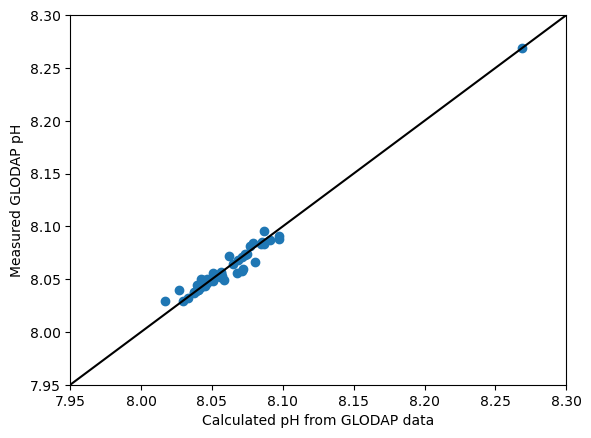

In [66]:
plt.plot(np.arange(7.95, 8.30, 0.05), np.arange(7.95, 8.30, 0.05), color="k")
plt.scatter(data_bgcargo_overlap["ph_4_calculated"], data_bgcargo_overlap["ph_4"])
plt.xlim(7.95, 8.30)
plt.ylim(7.95, 8.30)
plt.xlabel("Calculated pH from GLODAP data")
plt.ylabel("Measured GLODAP pH")
plt.savefig(fig_path + "calc_GLODAP_ph_vs_meas_GLODAP_ph.png", dpi=300)

In [77]:
print("Standard deviation for calculated pH: {:.4f}".format(np.std(
    data_bgcargo_overlap["ph_4_calculated"])))
rmse = np.sqrt(MSE(
    data_bgcargo_overlap["ph_4_calculated"], data_bgcargo_overlap["ph_4"]))
print("RMSE: {:.4f} ({:.2f}% of standard deviation)".format(
    rmse, 100 * rmse / np.std(data_bgcargo_overlap["ph_4_calculated"])))
print("(for completeness - standard deviation for measured pH: {:.4f})".format(np.std(
    data_bgcargo_overlap["ph_4"])))
print("Fraction of variance unexplained: {:.4f}".format(FVU(data_bgcargo_overlap["ph_4"],
                                                        data_bgcargo_overlap["ph_4_calculated"])))

Standard deviation for calculated pH: 0.0354
RMSE: 0.0058 (16.27% of standard deviation)
(for completeness - standard deviation for measured pH: 0.0345)
Fraction of variance unexplained: 0.0265


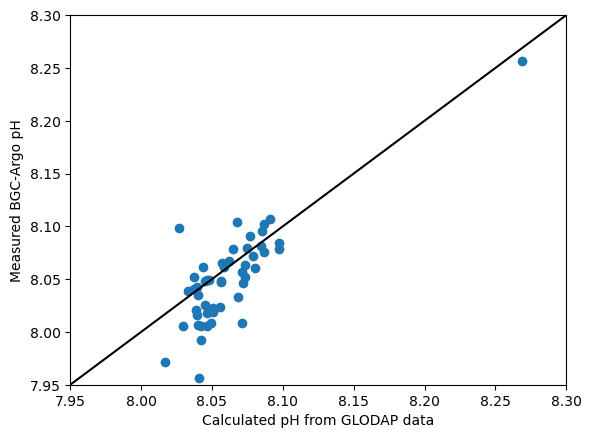

In [81]:
plt.plot(np.arange(7.95, 8.30, 0.05), np.arange(7.95, 8.30, 0.05), color="k")
plt.scatter(data_bgcargo_overlap["ph_4_calculated"], data_bgcargo_overlap["ph"])
plt.xlim(7.95, 8.30)
plt.ylim(7.95, 8.30)
plt.xlabel("Calculated pH from GLODAP data")
plt.ylabel("Measured BGC-Argo pH")
plt.savefig(fig_path + "calc_GLODAP_ph_vs_meas_bgc-argo_ph.png", dpi=300)

In [78]:
rmse = np.sqrt(MSE(
    data_bgcargo_overlap["ph_4_calculated"], data_bgcargo_overlap["ph"]))
print("RMSE: {:.4f} ({:.2f}% of standard deviation)".format(
    rmse, 100 * rmse / np.std(data_bgcargo_overlap["ph_4_calculated"])))
print("Fraction of variance unexplained: {:.4f}".format(FVU(data_bgcargo_overlap["ph"],
                               data_bgcargo_overlap["ph_4_calculated"])))

RMSE: 0.0280 (79.16% of standard deviation)
Fraction of variance unexplained: 0.6266


#### Plot GLODAP calculated fCO2 against SOCAT fCO2

In [59]:
is_overlapping = np.isfinite(data["fco2"] * data["talkos_4"])

print("Number of GLODAP4 samples: ", np.sum(np.isfinite(data["talkos_4"])))
print("Number of SOCAT samples: ", np.sum(np.isfinite(data["fco2"])))
print("Number of overlapping samples: ", np.sum(is_overlapping))

data_socat_overlap = {}
for key in ["talkos_4", "dissicos_4", "tos_4", "sos_4",
            "sios_4", "po4os_4", "fco2"]:
    data_socat_overlap[key] = data[key][is_overlapping]

Number of GLODAP4 samples:  10910
Number of SOCAT samples:  341467
Number of overlapping samples:  6345


In [60]:
data_socat_overlap["fco2_4_calculated"] = calc_fCO2(
    data_socat_overlap["talkos_4"], data_socat_overlap["dissicos_4"],
    data_socat_overlap["tos_4"], data_socat_overlap["sos_4"],
    data_socat_overlap["sios_4"], data_socat_overlap["po4os_4"])

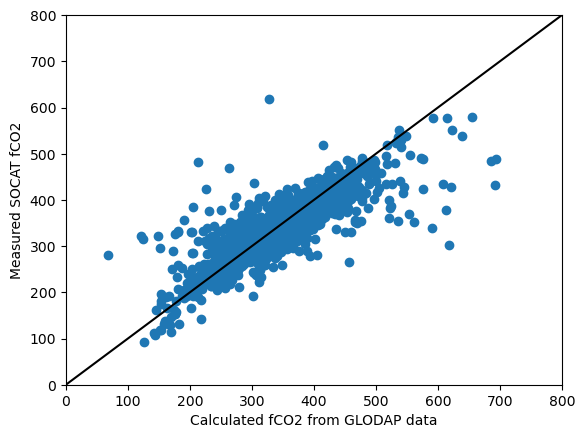

In [63]:
plt.plot(np.arange(0, 800), color="k")
plt.scatter(data_socat_overlap["fco2_4_calculated"], data_socat_overlap["fco2"])
plt.xlim(0, 800)
plt.ylim(0, 800)
plt.xlabel("Calculated fCO2 from GLODAP data")
plt.ylabel("Measured SOCAT fCO2")
plt.savefig(fig_path + "calc_GLODAP_fCO2_vs_meas_SOCAT_fCO2.png", dpi=300)

In [80]:
rmse = np.sqrt(MSE(
    data_socat_overlap["fco2_4_calculated"], data_socat_overlap["fco2"]))
print("RMSE: {:.2f} muatm ({:.2f}% of standard deviation)".format(
    rmse, 100 * rmse / np.std(data_socat_overlap["fco2_4_calculated"])))
print("Fraction of variance unexplained: {:.4f}".format(FVU(data_socat_overlap["fco2"],
                                                        data_socat_overlap["fco2_4_calculated"])))

RMSE: 33.85 muatm (63.29% of standard deviation)
Fraction of variance unexplained: 0.4006
